# Master notebook

In [80]:
VERSION = '0.0'
FILENAME = 'master'

In [81]:
from __future__ import absolute_import, division, print_function 
import os
import re
import sys
import time

sys.path.append(os.path.join('.', '..')) 
import utils
import utils_DL
import utils_s160159 as u_s

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import confusion_matrix

## Load data

In [82]:
data_dir = './../Data'
logs_path = './logs'
NUM_SUBJECTS = 20
NUM_CLASSES = 6

#VAL_PER = 0.05
#VAL_TRAIN_ID = NUM_SUBJECTS - int(NUM_SUBJECTS * VAL_PER) - 1
VAL_TRAIN_ID = NUM_SUBJECTS - 4

In [65]:
#Load all subjects into memory
subjects_list = []
for i in range(1,NUM_SUBJECTS+1):
    print("Loading subject %d of %d..." %(i,NUM_SUBJECTS), end='r')
    inputs_night1, targets_night1, _  = u_s.load_spectrograms(data_path=data_dir, subject_id=i, night_id=1)
    if(i!=20):
        inputs_night2, targets_night2, _  = u_s.load_spectrograms(data_path=data_dir, subject_id=i, night_id=2)
    else:
        inputs_night2 = np.empty((0,224,224,3),dtype='uint8')
        targets_night2 = np.empty((0,NUM_CLASSES),dtype='uint8')           

    current_inputs = np.concatenate((inputs_night1,inputs_night2),axis=0)
    current_targets = np.concatenate((targets_night1, targets_night2),axis=0)
    
    subjects_list.append([current_inputs, current_targets])
        
# extract image shapes
IMAGE_SHAPE = subjects_list[0][0].shape

Loading subject 1...
Loading subject 2...
Loading subject 3...
Loading subject 4...
Loading subject 5...
Loading subject 6...
Loading subject 7...
Loading subject 8...
Loading subject 9...
Loading subject 10...
Loading subject 11...
Loading subject 12...
Loading subject 13...
Loading subject 14...
Loading subject 15...
Loading subject 16...
Loading subject 17...
Loading subject 18...
Loading subject 19...
Loading subject 20...


## Building the model

In [87]:
# hyperameters
HEIGTH, WIDTH, NCHANNELS = IMAGE_SHAPE[1], IMAGE_SHAPE[2], IMAGE_SHAPE[3]
PADDING = 'same'
L_RATE = 10e-5
L_RATE_MO_1 = 0.9
L_RATE_MO_2 = 0.999
EPS = 1e-8
TRAIN_FEATURES = False

In [88]:
# https://www.cs.toronto.edu/~frossard/vgg16/vgg16.py

# Load the weights into memory
weights_dict = np.load(data_dir + '/' + 'vgg16_weights.npz', encoding='bytes')

def tf_conv2d(inputs, name, trainable=TRAIN_FEATURES):
    with tf.name_scope(name) as scope:
        kernel = tf.get_variable(shape=weights_dict[name + '_W'].shape, 
                                 initializer=tf.constant_initializer(weights_dict[name + '_W']), 
                                 name=scope + 'weights', 
                                 trainable=trainable)
        
        conv = tf.nn.conv2d(inputs, kernel, strides=[1, 1, 1, 1], padding='SAME')
        
        biases = tf.get_variable(shape=weights_dict[name + '_b'].shape,
                                 initializer=tf.constant_initializer(weights_dict[name + '_b']), 
                                 trainable=trainable, name=scope + 'biases')

        return(tf.nn.relu(tf.nn.bias_add(conv, biases), name=scope))
        

def tf_max_pooling2d(inputs, name):
    with tf.name_scope(name) as scope:
        return(tf.nn.max_pool(inputs,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name=scope))        

def tf_fully_con(inputs, name, shape=[None, 4096]):
    with tf.name_scope(name) as scope:    
        fc_W = tf.get_variable(shape=shape, 
                               initializer=tf.contrib.layers.xavier_initializer(dtype=tf.float32,
                                                                                seed=22),
                               name=scope + 'weights', trainable=True)

        fc_b = tf.get_variable(shape=shape[1], 
                               initializer=tf.random_normal_initializer(mean=0, stddev=0.01, dtype=tf.float32),
                               trainable=True, name=scope + 'biases')
        
        in_flat = tf.reshape(inputs, [-1, shape[0]])
        return(tf.nn.relu(tf.nn.bias_add(tf.matmul(in_flat, fc_W), fc_b)))
        

In [89]:
# init model
tf.reset_default_graph()

# init placeholders
x_pl = tf.placeholder(tf.float32, [None, HEIGTH, WIDTH, NCHANNELS], name='input_placeholder')
y_pl = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='target_placeholder')


print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('--------------------------------------------')

with tf.variable_scope('VVG16_layer'):
    print('x_pl \t\t', x_pl.get_shape())
    # level one
    conv1_1 = tf_conv2d(inputs=x_pl, name='conv1_1')
    conv1_2 = tf_conv2d(inputs=conv1_1, name='conv1_2')
    pool1 = tf_max_pooling2d(inputs=conv1_2, name='pool1')
    print('conv1_1 \t', conv1_1.get_shape())
    print('conv1_2 \t', conv1_2.get_shape())
    print('pool1 \t\t', pool1.get_shape())
    print('--------------------------------------------')
    
    # level two
    conv2_1 = tf_conv2d(inputs=pool1, name='conv2_1')
    conv2_2 = tf_conv2d(inputs=conv2_1, name='conv2_2')
    pool2 = tf_max_pooling2d(inputs=conv2_2, name='pool2')
    print('conv2_1 \t', conv2_1.get_shape())
    print('conv2_2 \t', conv2_2.get_shape())
    print('pool2 \t\t', pool2.get_shape())
    print('--------------------------------------------')
    
    # level three
    conv3_1 = tf_conv2d(inputs=pool2, name='conv3_1')
    conv3_2 = tf_conv2d(inputs=conv3_1, name='conv3_2')
    conv3_3 = tf_conv2d(inputs=conv3_2, name='conv3_3')
    pool3 = tf_max_pooling2d(inputs=conv3_3, name='pool_3')
    print('conv3_1 \t', conv3_1.get_shape())
    print('conv3_2 \t', conv3_2.get_shape())
    print('conv3_3 \t', conv3_3.get_shape())
    print('pool3 \t\t', pool3.get_shape())
    print('--------------------------------------------')
    
    # level four
    conv4_1 = tf_conv2d(inputs=pool3, name='conv4_1')
    conv4_2 = tf_conv2d(inputs=conv4_1, name='conv4_2')
    conv4_3 = tf_conv2d(inputs=conv4_2, name='conv4_3')
    pool4 = tf_max_pooling2d(inputs=conv4_3, name='pool_4')
    print('conv4_1 \t', conv4_1.get_shape())
    print('conv4_2 \t', conv4_2.get_shape())
    print('conv4_3 \t', conv4_3.get_shape())
    print('pool4 \t\t', pool4.get_shape())
    print('--------------------------------------------')

    # level five
    conv5_1 = tf_conv2d(inputs=pool4, name='conv5_1')
    conv5_2 = tf_conv2d(inputs=conv5_1, name='conv5_2')
    conv5_3 = tf_conv2d(inputs=conv5_2, name='conv5_3')
    pool5 = tf_max_pooling2d(inputs=conv5_3, name='pool_5')
    print('conv5_1 \t', conv5_1.get_shape())
    print('conv5_2 \t', conv5_2.get_shape())
    print('conv5_3 \t', conv5_3.get_shape())
    print('pool5 \t\t', pool5.get_shape())
    print('--------------------------------------------')

    # level six
    fc6 = tf_fully_con(inputs=pool5, name='fc6', shape=[int(np.prod(pool5.get_shape()[1:])), 4096])
    fc6_dropout = tf.layers.dropout(inputs=fc6, name='fc6_dropout', rate=0.5)

    # level seven
    fc7 = tf_fully_con(inputs=fc6_dropout, name='fc7', shape=[4096, 4096])
    fc7_dropout = tf.layers.dropout(inputs=fc7, name='fc7_dropout', rate=0.5)

    # level eigth
    fc8 = tf_fully_con(inputs=fc7_dropout, name='fc7', shape=[4096, NUM_CLASSES])
    #fc8 = tf_fully_con(inputs=fc7_dropout, name='fc7', shape=[4096, 1000])
    
    print('fc6 \t', fc6.get_shape())
    print('fc7 \t', fc7.get_shape())
    print('fc8 \t', fc8.get_shape()) 
    print('--------------------------------------------')


    
with tf.variable_scope('output_layer'):    
    l_out = tf.nn.softmax(fc8, name='l_out')
    print('out \t', l_out.get_shape())
    print('--------------------------------------------')
    
print('Model consits of ', utils_DL.num_params(), 'trainable parameters.')
## print all the variable names and shapes
#for var in tf.global_variables ():
#    s = var.name + " "*(40-len(var.name))
#    print(s, var.value().get_shape())

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
--------------------------------------------
x_pl 		 (?, 224, 224, 3)
conv1_1 	 (?, 224, 224, 64)
conv1_2 	 (?, 224, 224, 64)
pool1 		 (?, 112, 112, 64)
--------------------------------------------
conv2_1 	 (?, 112, 112, 128)
conv2_2 	 (?, 112, 112, 128)
pool2 		 (?, 56, 56, 128)
--------------------------------------------
conv3_1 	 (?, 56, 56, 256)
conv3_2 	 (?, 56, 56, 256)
conv3_3 	 (?, 56, 56, 256)
pool3 		 (?, 28, 28, 256)
--------------------------------------------
conv4_1 	 (?, 28, 28, 512)
conv4_2 	 (?, 28, 28, 512)
conv4_3 	 (?, 28, 28, 512)
pool4 		 (?, 14, 14, 512)
--------------------------------------------
conv5_1 	 (?, 14, 14, 512)
conv5_2 	 (?, 14, 14, 512)
conv5_3 	 (?, 14, 14, 512)
pool5 		 (?, 7, 7, 512)
--------------------------------------------
fc6 	 (?, 4096)
fc7 	 (?, 4096)
fc8 	 (?, 6)
--------------------------------------------
out 	 (?, 6)
-----------------------

### OPTIMISATION

In [90]:
with tf.variable_scope('loss_function'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(l_out + EPS), axis=[1])
    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=L_RATE, 
                                       beta1=L_RATE_MO_1, 
                                       beta2=L_RATE_MO_2)
    # applying the gradients
    #train_op = optimizer.minimize(cross_entropy, global_step=global_step)
    train_op = optimizer.minimize(cross_entropy)
    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    prediction = tf.one_hot(tf.argmax(l_out, axis=1), depth=NUM_CLASSES)
    correct_prediction = tf.equal(tf.argmax(l_out, axis=1), tf.argmax(y_pl, axis=1))
    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
with tf.variable_scope('sensitivity_map'):
    # https://stackoverflow.com/questions/35226428/how-do-i-get-the-gradient-of-the-loss-at-a-tensorflow-variable
    # https://www.tensorflow.org/versions/r0.12/api_docs/python/train/gradient_computation
    grad_output_wrt_input = tf.gradients(cross_entropy, [x_pl],
                                         name='grad_output_wrt_input')[0]

### Test flow for model

In [91]:
## Launch TensorBoard, and visualize the TF graph
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.20)

# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    # writer = tf.summary.FileWriter(logs_path, sess.graph)
    # close session
    # sess.close()
# run in terminal
# """
# python -m webbrowser "http://localhost:6006/";
# tensorboard --logdir='./logs'
# """

In [107]:
# Test the forward pass    
x_batch = subjects_list[0][0][0:4]
y_batch = subjects_list[0][1][0:4]

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=l_out, feed_dict={x_pl: x_batch})
    # x_batch = np.float32(x_batch)/255.0
    _grads, _preds = sess.run(fetches=[grad_output_wrt_input, prediction], 
                         feed_dict={x_pl: x_batch,
                                    y_pl: y_batch})
    saver = tf.train.Saver()
    saver.save(sess, "./models/basis/model")
    # save trainable variables
    # trainable_variables_dict = {}
    # for tv in tf.trainable_variables():
    #     trainable_variables_dict[tv.name] = sess.run(tv)  
    # START_TIME = time.ctime()
    # MODEL_PATH = "./models/"+ FILENAME + "/Version_" + VERSION + "_" + START_TIME   
    # if not os.path.exists(MODEL_PATH): os.makedirs(MODEL_PATH)
    # # save current fold parameters
    # np.save(MODEL_PATH + "/tf_fold_" + str(fold) + "_trainable_variables_dict.npy", trainable_variables_dict)
    
assert y_pred.shape == np.zeros((len(x_batch),NUM_CLASSES)).shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(l_out.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

# close session
sess.close()

Forward pass successful!


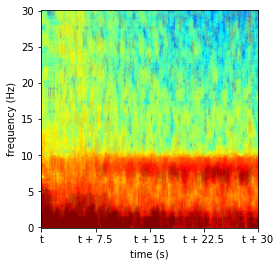

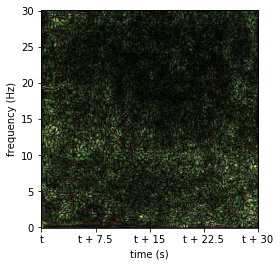

In [108]:
grad_accum = np.empty((0,IMAGE_SHAPE[1],IMAGE_SHAPE[2],IMAGE_SHAPE[3]))
grad_accum = np.concatenate((grad_accum, _grads), axis=0)

u_s.cal_sen_map(x_batch, sen_map_class='raw_1', save_dir = './pics/', IMAGE_SHAPE=IMAGE_SHAPE)
u_s.cal_sen_map(grad_accum, sen_map_class='loss_1', save_dir = './pics/', IMAGE_SHAPE=IMAGE_SHAPE)

## Train the model

In [ ]:
# Training Loop
MAX_EPOCHS = 1 # 50
BATCH_SIZE = 75

# reset counter 
fetches_train = [train_op, cross_entropy, accuracy]
fetches_valid = [cross_entropy, accuracy, prediction]
fetches_test = [cross_entropy, accuracy, prediction]

capture_dict = {}

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    try:
        START_TIME = time.ctime()
        MODEL_PATH = "./models/"+ FILENAME + "/Version_" + VERSION + "_" + START_TIME
        if not os.path.exists(MODEL_PATH): os.makedirs(MODEL_PATH)
        # initlize variables    
        sess.run(tf.global_variables_initializer())
        print('Begin training loop... \n')
        
        # INTO VALIDATION
        idx_val = list(range(VAL_TRAIN_ID, NUM_SUBJECTS))
        val_data = [subjects_list[i] for i in idx_val]
        inputs_val = np.empty((0,224,224,3),dtype='uint8')  
        targets_val = np.empty((0,NUM_CLASSES),dtype='uint8')
        for item in val_data:
            inputs_val = np.concatenate((inputs_val, item[0]),axis=0)
            targets_val = np.concatenate((targets_val, item[1]),axis=0)

        # cross validation
        # loo = KFold(n_splits=10)
        loo = LeaveOneOut()
        fold = 1   
        for idx_train, idx_test in loo.split(list(range(VAL_TRAIN_ID))):
            print("Fold %d\t of %d" %(fold, loo.get_n_splits(list(range(VAL_TRAIN_ID)))))
            capture_dict[fold] = {}
            #
            valid_loss, valid_accuracy = [], []
            train_loss, train_accuracy = [], []
            test_loss, test_accuracy = [], []
            
            #INTO TRAIN 
            train_data = [subjects_list[i] for i in idx_train]
            inputs_train = np.empty((0,224,224,3),dtype='uint8')  
            targets_train = np.empty((0,NUM_CLASSES),dtype='uint8') 
            for item in train_data:
                inputs_train = np.concatenate((inputs_train, item[0]),axis=0)
                targets_train = np.concatenate((targets_train, item[1]),axis=0)
            
            # INTO TEST
            test_data = [subjects_list[i] for i in idx_test]
            inputs_test = np.empty((0,224,224,3), dtype='uint8')  
            targets_test = np.empty((0,NUM_CLASSES), dtype='uint8')
            for item in test_data:
                inputs_test = np.concatenate((inputs_test,item[0]), axis=0)
                targets_test = np.concatenate((targets_test,item[1]), axis=0) 
            
            # Loop epochs
            for epoch in range(MAX_EPOCHS):
                print('\tEpoch: ' + str(epoch + 1) + ' of ' + str(MAX_EPOCHS))
                # loop mini batches
                _train_loss, _train_accuracy = [], []
                _iter = 1
                for x_batch, y_batch in utils.iterate_minibatches(batchsize=BATCH_SIZE, 
                                                                  inputs=inputs_train, 
                                                                  targets=targets_train, 
                                                                  shuffle=False):
                    # feed dict.
                    feed_dict_train = {x_pl: x_batch, 
                                       y_pl: y_batch}
                    _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
                    # append to epoch
                    _train_loss.append(_loss)
                    _train_accuracy.append(_acc)                    
                    #
                    print("\t\titer: %d\t L: %f\t ACCs: %f" %(_iter, 
                                                            np.nanmean(_train_loss), 
                                                            np.nanmean(_train_accuracy)), 
                          end='\r')
                    _iter += 1
                    # end loop
                # end loop

            # COMPUTE VALIDATION LOSS AND ACCURACY
            print('\tEvaluate validation performance')
            pred = np.empty((0,NUM_CLASSES),dtype='uint8')
            # append mean loss and accuracy
            train_loss.append(np.nanmean(_train_loss))
            train_accuracy.append(np.nanmean(_train_accuracy))
            _iter = 1
            #
            for x_batch, y_batch in utils.iterate_minibatches(batchsize=BATCH_SIZE, 
                                                              inputs=inputs_val, 
                                                              targets=targets_val, 
                                                              shuffle=False):
                #
                feed_dict_valid = {x_pl: x_batch, y_pl: y_batch}
                _loss, _acc, _pred = sess.run(fetches_valid, feed_dict_valid)
                # append prediction
                pred = np.concatenate((pred, _pred),axis=0)
                # append mean
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("\t\titer: %d\t tra_L: %f\t tra_ACCs: %f\t val_L: %f\t val_ACCs: %f" %(_iter,
                                                                                             train_loss[-1], 
                                                                                             train_accuracy[-1],
                                                                                             np.nanmean(valid_loss), 
                                                                                             np.nanmean(valid_accuracy)), 
                      end='\r')
                _iter += 1
                # end loop
            # calculate performance
            cm_val = confusion_matrix(y_pred=np.where(pred ==1)[1], 
                                  y_true=np.where(targets_val ==1)[1], 
                                  labels=list(range(NUM_CLASSES)))

            # COMPUTE TEST LOSS AND ACCURACY   
            print('\tEvaluate test performance')
            pred = np.empty((0,NUM_CLASSES),dtype='uint8')
            _iter = 1
            for x_batch, y_batch in utils.iterate_minibatches(batchsize=BATCH_SIZE, 
                                                              inputs=inputs_test, 
                                                              targets=targets_test, 
                                                              shuffle=False):
                #
                feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
                _loss, _acc, _pred = sess.run(fetches_test, feed_dict_test)
                # append prediction
                pred = np.concatenate((pred, _pred),axis=0)
                test_loss.append(_loss)
                test_accuracy.append(_acc)
                print("\t\titer: %d\t L: %f\t ACCs: %f" %(_iter,
                                                          np.nanmean(test_loss), 
                                                          np.nanmean(test_accuracy)), 
                      end='\r')
                _iter += 1
                # end loop tests
            
            # calculate performance
            cm_test = confusion_matrix(y_pred=np.where(pred ==1)[1], 
                                  y_true=np.where(targets_test ==1)[1], 
                                  labels=list(range(NUM_CLASSES)))
            
            # CAPTURE STATS FOR CURRENT FOLD
            capture_dict[fold] = {'cm_test': cm_test,
                                  'cm_val': cm_val,
                                  'train_loss': np.nanmean(train_loss),
                                  'train_accuracy': np.nanmean(train_accuracy),
                                  'test_loss': np.nanmean(test_loss),
                                  'test_accuracy': np.nanmean(test_accuracy),
                                  'valid_loss': np.nanmean(valid_loss),
                                  'valid_accuracy': np.nanmean(valid_accuracy)} 
            
                
             
            # SAVE STATS FOR CURRENT FOLD
            np.save(MODEL_PATH + "/capture_dict.npy", capture_dict)
            # tf model
            # trainable_variables_dict = {}
            # for tv in tf.trainable_variables(): trainable_variables_dict[tv.name] = sess.run(tv)
            # np.save(MODEL_PATH + "/tf_fold_" + str(fold) + "_trainable_variables_dict.npy", 
            #        trainable_variables_dict)
            # print("Model and parameters saved...")

            # increase fold
            fold += 1        
        # end loop and traning    
        print('\n... end training loop')
        print('started at: ' + START_TIME)
        print('ended at:   ' + time.ctime())
        
        # close session
        sess.close()

    except KeyboardInterrupt:
        pass